# NBA Player  Performance - Analytical Insights

## Purpose

This notebook builds on the validated, player-game level dataset produced during exploratory data analysis.
The objective here is to extract **meaningful insights** related to scoring beavior, consistency, and contextual differences acreoss seasonsand competition types.

All analyses are performed on a cleaned and validated dataset to ensure realiability of results.

In [1]:
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 



## Load Analysis-Ready Dataset

The player-game scoring dataset was derived and validated during the EDA phase.
Here, we load the processed dataset and enrich it with game-level context.

In [2]:
player_game_points=pd.read_csv("../data/processed/player_game_points.csv")
player_game_points.head()


,game_id,player1_id,final_points,full_name
0,11300001,200757,8,Thabo Sefolosha
1,11300001,201142,24,Kevin Durant
2,11300001,201586,15,Serge Ibaka
3,11300001,201934,4,Hasheem Thabeet
4,11300001,202704,9,Reggie Jackson


## Add Game Context

To support season-level and competition-type analysis, we merge game metadata 
including season identifiers and season type.

In [3]:
DB_PATH="../data/raw/nba.sqlite"
conn = sqlite3.connect(DB_PATH)

df_games= pd.read_sql("""
SELECT game_id, season_id, season_type, game_date
FROM game;
""", conn)

#Ensure merge keys have same dtypes

player_game_points["game_id"]=player_game_points["game_id"].astype(str)
df_games["game_id"]=df_games["game_id"].astype(str)

player_game= player_game_points.merge(df_games, on="game_id", how="left")
player_game.head()

,game_id,player1_id,final_points,full_name,season_id,season_type,game_date
0,11300001,200757,8,Thabo Sefolosha,NaN,NaN,NaN
1,11300001,201142,24,Kevin Durant,NaN,NaN,NaN
2,11300001,201586,15,Serge Ibaka,NaN,NaN,NaN
3,11300001,201934,4,Hasheem Thabeet,NaN,NaN,NaN
4,11300001,202704,9,Reggie Jackson,NaN,NaN,NaN


## Highest Single-Game Scoring Performances 

We begin by identifying the most extreme scoring performance observed in the dataset. 
These outliers help validate the upper bounds of player scoring and highlight historically
significant games.

In [4]:
top_games = player_game.sort_values("final_points", ascending=False).head()
top_games[
    ["full_name","final_points", "season_id", "season_type","game_date"]
]

,full_name,final_points,season_id,season_type,game_date
117612,Kobe Bryant,81,NaN,NaN,NaN
440781,Damian Lillard,71,NaN,NaN,NaN
434622,Donovan Mitchell,71,NaN,NaN,NaN
142592,Kobe Bryant,65,NaN,NaN,NaN
251443,Carmelo Anthony,62,NaN,NaN,NaN


## Distribution of Career Average Scoring

To understand how rare elite scorers are, we examine the distribution of career
average points per game across players with sufficient sample size.

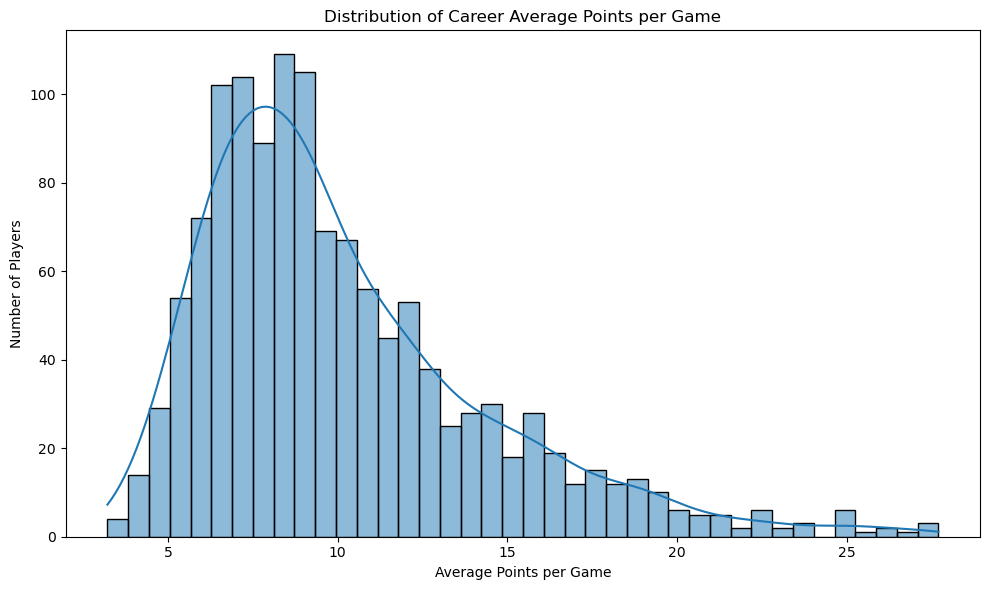

In [5]:
career_avg=(
    player_game
    .groupby("full_name", as_index=False)
    .agg(
        games_played=("final_points", "count"),
        avg_points=("final_points","mean")
    )
    .query("games_played >= 100")
)

plt.figure(figsize=(10,6))
sns.histplot(career_avg["avg_points"], bins=40, kde=True)

plt.title("Distribution of Career Average Points per Game")
plt.xlabel("Average Points per Game")
plt.ylabel("Number of Players")

plt.tight_layout()
plt.savefig("../figures/analysis_career_avg_points_distribution.png", dpi=300)
plt.show()

## Scoring Consistency: Average vs Variability 

High scoring alone does not imply reliability. This section evaluates player
scoring consistency by comparing average points per game against game-to-game
variability.

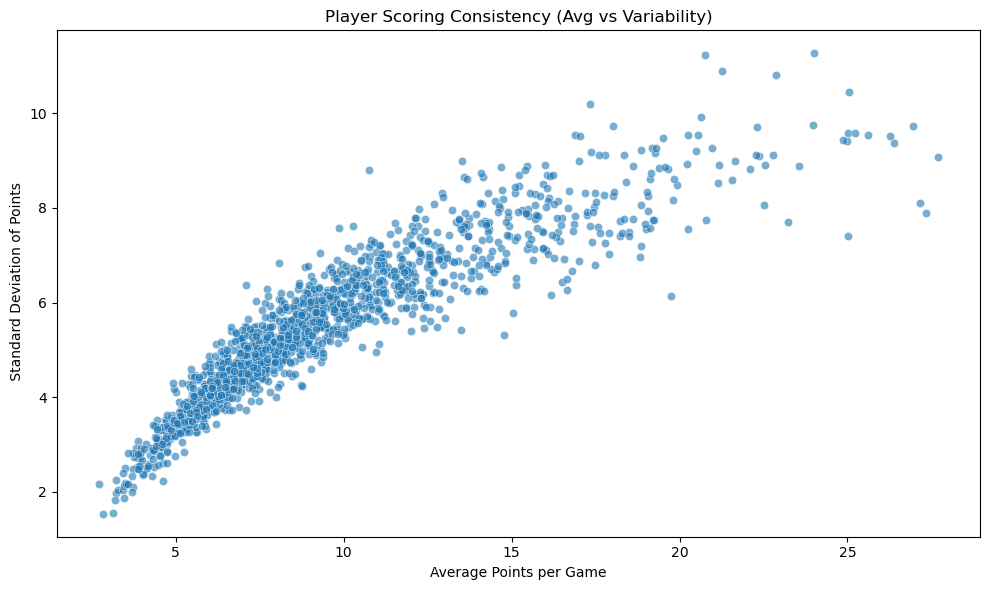

In [6]:
scoring_profile=(
    player_game
    .groupby("full_name", as_index= False)
    .agg(
        games_played=("final_points","count"),
        avg_points=("final_points","mean"),
        std_points=("final_points","std")
    )
    .query("games_played >=50")
)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=scoring_profile,
    x="avg_points",
    y="std_points",
    alpha=0.6
)

plt.title("Player Scoring Consistency (Avg vs Variability)")
plt.xlabel("Average Points per Game")
plt.ylabel(" Standard Deviation of Points")

plt.tight_layout()
plt.savefig("../figures/analysis_scoring_consistency.png", dpi=300)
plt.show()

## Regular Season vs Playoff Scoring 

Scoring enviroments differ significantly between the Regular Season and Playoff.
We compare average player scoring across competition types to queantify this effect.

In [7]:
player_game_points["game_id"]=(
    player_game_points["game_id"]
    .astype(str)
    .str.strip()
    .str.zfill(10)
)

df_games["game_id"]=(
    df_games["game_id"]
    .astype(str)
    .str.strip()
    .str.zfill(10)
)

player_game=player_game_points.merge(df_games, on="game_id", how="left")

In [8]:
player_game["season_type"].value_counts(dropna=False).head(10)

Regular Season    498992
Playoffs           30364
Pre Season         15206
All Star             440
All-Star             375
Name: season_type, dtype: int64

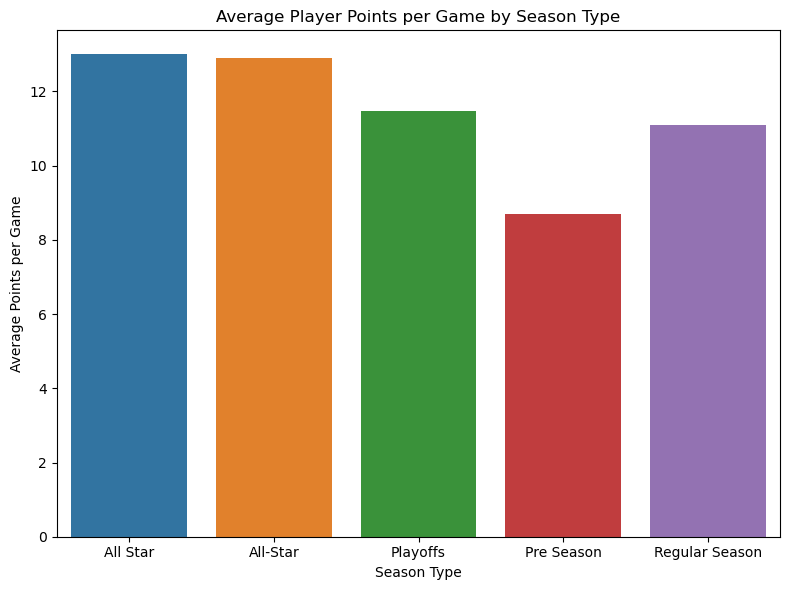

In [9]:
season_type_avg=(
    player_game
    .groupby("season_type", as_index=False)
    .agg(avg_points=("final_points","mean"))
)

plt.figure(figsize=(8,6))
sns.barplot(data= season_type_avg, x="season_type", y="avg_points")

plt.title("Average Player Points per Game by Season Type")
plt.xlabel("Season Type")
plt.ylabel("Average Points per Game")

plt.tight_layout()
plt.savefig("../figures/analysis_regular_vs_playoff.png", dpi=300)
plt.show()

## Scoring Trends Over Time 

Finally, we analyze how avergae player scoring has evolved across seasons,
highlighting long-term structural changes in pace and offensive efficiency.

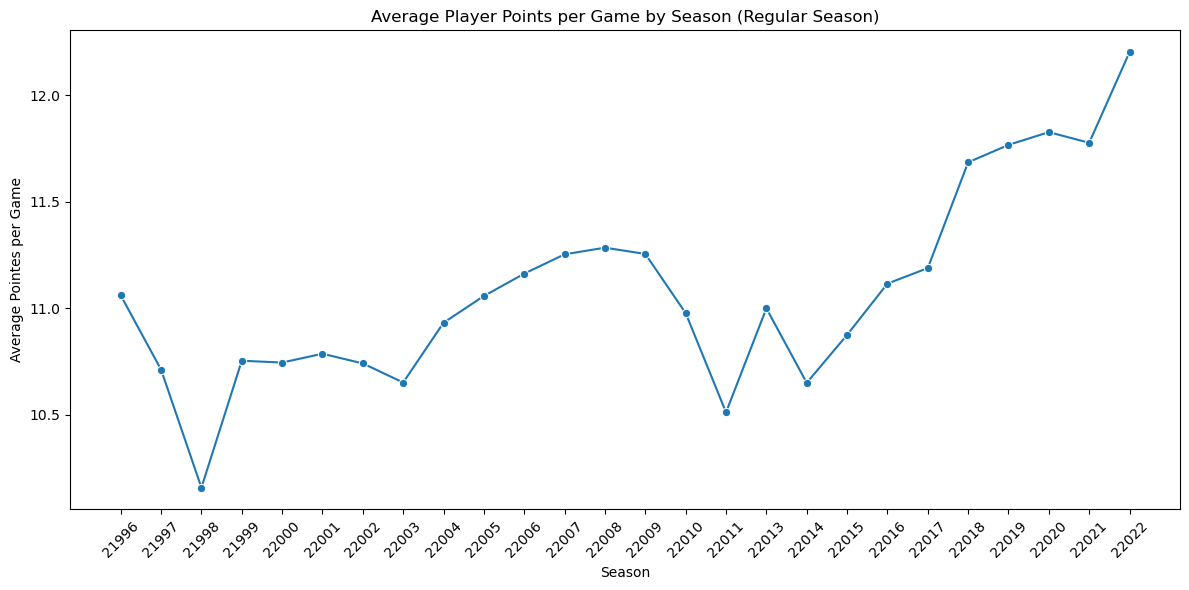

In [10]:
season_avg=(
    player_game
    .query("season_type=='Regular Season'")
    .groupby("season_id", as_index= False)
    .agg(avg_points=("final_points", "mean"))
)

season_avg["season_sort"]=(
    season_avg["season_id"].astype(str).str.extract(r"(\d+)",expand= False).astype(float)
)
season_avg = season_avg.sort_values("season_sort")

plt.figure(figsize=(12,6))
sns.lineplot(data= season_avg, x="season_id", y="avg_points", marker="o")

plt.title("Average Player Points per Game by Season (Regular Season)")
plt.xlabel("Season")
plt.ylabel("Average Pointes per Game")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("../figures/analysis_avg_points_by_season.png", dpi=300)
plt.show()


## Player Scoring vs Team Scoring Environment

Player scoring output is influenced by team offensive context. 
We examine how individual scoring relates to total team points in a game.

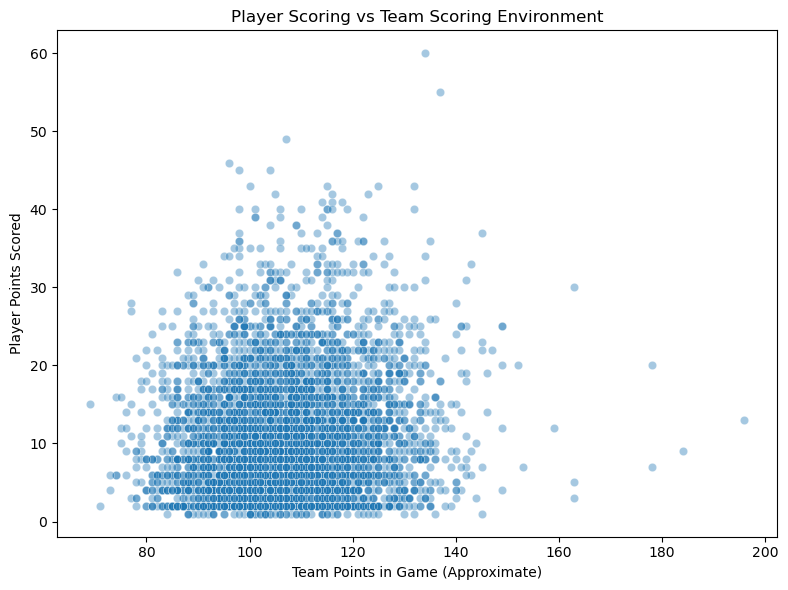

In [11]:
#Load team scoring from game table 
df_team_points= pd.read_sql("""
SELECT
    game_id,
    pts_home,
    pts_away
FROM game;
""", conn)

#Merge team points 

player_game_team= player_game.merge(df_team_points, on="game_id", how="left")

#Aproximate team points per player (home/away not assigned yet) 

player_game_team["team_points_estimate"]=(
    player_game_team[["pts_home","pts_away"]].max(axis=1)
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=player_game_team.sample(5000, random_state=42),
    x="team_points_estimate",
    y="final_points",
    alpha=0.4
)

plt.title("Player Scoring vs Team Scoring Environment")
plt.xlabel("Team Points in Game (Approximate)")
plt.ylabel("Player Points Scored")

plt.tight_layout()
plt.savefig("../figures/player_scoring_vs_team_scoring_environment.png", dpi=300)
plt.show()

## Rebound Events as a Potencial Modeling Feature

While this project focuses primarly on scoring, play-by-play data
also enables derivation of additional performance metrics suchas rebounds.
We explore rebound event frequency to assess feasibility for future modeling.

In [12]:
df_rebounds= pd.read_sql("""
SELECT
    game_id,
    player1_id,
    homedescription,
    visitordescription
FROM play_by_play
WHERE homedescription LIKE '%REBOUND%'
    OR visitordescription LIKE '%REBOUND%';
""", conn)

df_rebounds.head()

,game_id,player1_id,homedescription,visitordescription
0,0029600012,406,O'Neal REBOUND (Off:0 Def:1),None
1,0029600012,208,None,Cassell REBOUND (Off:0 Def:1)
2,0029600012,1610612747,LAKERS Rebound,None
3,0029600012,76,Ceballos REBOUND (Off:0 Def:1),None
4,0029600012,170,None,Kleine REBOUND (Off:1 Def:0)


In [13]:
df_players = pd.read_sql("""
SELECT id AS player_id, full_name
FROM player;
""", conn)


In [14]:
valid_player_ids = set(df_players["player_id"].astype(str))

rebound_counts_named = (
    df_rebounds
        .assign(player1_id=lambda x: x["player1_id"].astype(str))
        .groupby("player1_id")
        .size()
        .reset_index(name="rebound_events")
        .query("player1_id in @valid_player_ids")
        .merge(
            df_players.assign(player_id=df_players["player_id"].astype(str)),
            left_on="player1_id",
            right_on="player_id",
            how="left"
        )
        .drop(columns="player_id")
        .sort_values("rebound_events", ascending=False)
)

rebound_counts_named.head(10)


,player1_id,rebound_events,full_name
187,1495,15313,Tim Duncan
2149,2730,13948,Dwight Howard
2373,708,13436,Kevin Garnett
2076,2544,11367,LeBron James
1929,2200,11054,Pau Gasol
1041,1717,10962,Dirk Nowitzki
135,1112,9989,Ben Wallace
1364,201599,9921,DeAndre Jordan
2287,406,9586,Shaquille O'Neal
1927,2199,9380,Tyson Chandler


## Feature Relationships and Correlation Structure

Befor building predictive models, it is useful to understand
relationships between numerical features at the player-game level.

In [15]:
numeric_features=player_game_team[[
        "final_points",
        "team_points_estimate"
]].dropna()

numeric_features.corr()

,final_points,team_points_estimate
final_points,1.000000,0.098027
team_points_estimate,0.098027,1.000000


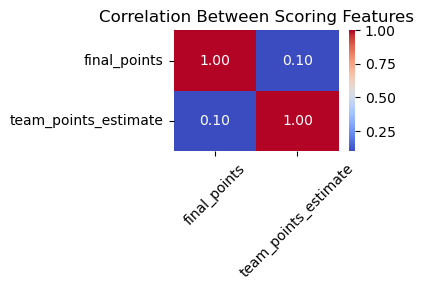

In [19]:
plt.figure(figsize=(4,3))
sns.heatmap(
    numeric_features.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation Between Scoring Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../figures/correlation_between_scoring_feature.png", dpi=300)
plt.show()

## Key Takeaways 
    -Player scoring distributions are heavily right-skewed, with elite scorers representing a smal subset.
    -High-average scorers often exhibit increased variability, highlighting trade-offs between volume and consistency.
    -Playoff scoring is generally lower than Regular Season scoring, reflecting tighter defensive environments.
    -Long-term scoring trends suggest structural changes in offensive style and pace across eras. 
    -The dataset supports extension to  multi-metric player modeling, including rebounds and contextual team-level features.
    
    
 These findings demostrate how raw event-le-vel data can be transfered into meaningful performance insights.